<a href="https://colab.research.google.com/github/MizeroR/summative-model-training-2025/blob/main/Copy_of_Reine_Mizero_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealWaste Image Classification: Traditional ML vs Deep Learning
# Dataset: 4752 images across 9 waste material categories from authentic landfill environment




# 1. SETUP AND IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Traditional ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.18.0
GPU Available: True


In [ ]:
CLASS_LABELS = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

# Dataset parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = len(CLASS_LABELS)
DATASET_SIZE = 4752


# 2. DOWNLOAD DATASET FROM UCI REPOSITORY


In [ ]:
print("DOWNLOADING REALWASTE DATASET")

DATASET_URL = "https://archive.ics.uci.edu/static/public/908/realwaste.zip"
DATASET_ZIP = "realwaste.zip"
EXTRACT_DIR = "realwaste_data"

print(f"\nDownloading dataset from: {DATASET_URL}")
print("This may take a few minutes depending on your connection...")

!wget -q --show-progress {DATASET_URL} -O {DATASET_ZIP}

print("\n✓ Download complete!")

DOWNLOADING REALWASTE DATASET

This may take a few minutes depending on your connection...
realwaste.zip           [                 <=>] 656.65M  14.7MB/s    in 18s     

✓ Download complete!


In [ ]:
# Extract dataset
print(f"\nExtracting dataset to: {EXTRACT_DIR}/")
!unzip -o -q {DATASET_ZIP} -d {EXTRACT_DIR}

print("✓ Extraction complete!")

# List downloaded files to understand structure
print("\nInspecting dataset structure...")
!ls -la {EXTRACT_DIR}

import os
from pathlib import Path

# Find the root directory containing class folders
def find_data_root(extract_dir):
    """Find the directory containing the actual image class folders"""
    for root, dirs, files in os.walk(extract_dir):
        # Check if this directory contains folders with our class names
        dir_names = [d.lower() for d in dirs]
        if any(cls.lower().replace(' ', '_') in dir_names or
               cls.lower().replace(' ', '-') in dir_names or
               cls.lower().replace(' ', '') in dir_names
               for cls in CLASS_LABELS):
            return root
    return extract_dir

DATA_ROOT = find_data_root(EXTRACT_DIR)
print(f"\nData root directory: {DATA_ROOT}")
print("\nDirectories found:")
!ls -la {DATA_ROOT}


Extracting dataset to: realwaste_data/
✓ Extraction complete!

Inspecting dataset structure...
total 12
drwxr-xr-x 3 root root 4096 Oct 17 20:27 .
drwxr-xr-x 4 root root 4096 Oct 17 20:27 ..
drwxr-xr-x 3 root root 4096 Dec  1  2023 realwaste-main

Data root directory: realwaste_data/realwaste-main/RealWaste

Directories found:
total 232
drwxr-xr-x 11 root root  4096 Dec  1  2023  .
drwxr-xr-x  3 root root  4096 Dec  1  2023  ..
drwxr-xr-x  2 root root 20480 Dec  1  2023  Cardboard
drwxr-xr-x  2 root root 20480 Dec  1  2023 'Food Organics'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Glass
drwxr-xr-x  2 root root 36864 Dec  1  2023  Metal
drwxr-xr-x  2 root root 32768 Dec  1  2023 'Miscellaneous Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Paper
drwxr-xr-x  2 root root 36864 Dec  1  2023  Plastic
drwxr-xr-x  2 root root 20480 Dec  1  2023 'Textile Trash'
drwxr-xr-x  2 root root 20480 Dec  1  2023  Vegetation


# 3. DATASET CONFIGURATION


In [ ]:
# data directory
DATA_DIR = DATA_ROOT

print(f"\nDataset Configuration:")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Total Instances: {DATASET_SIZE}")
print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Classes: {', '.join(CLASS_LABELS)}")
print(f"Data Directory: {DATA_DIR}")


Dataset Configuration:
Number of Classes: 9
Total Instances: 4752
Image Size: 224x224
Classes: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation
Data Directory: realwaste_data/realwaste-main/RealWaste


# 4. DATA LOADING AND EXPLORATION


✓ Found 461 images for 'Cardboard' in directory 'Cardboard'
✓ Found 411 images for 'Food Organics' in directory 'Food Organics'
✓ Found 420 images for 'Glass' in directory 'Glass'
✓ Found 790 images for 'Metal' in directory 'Metal'
✓ Found 495 images for 'Miscellaneous Trash' in directory 'Miscellaneous Trash'
✓ Found 500 images for 'Paper' in directory 'Paper'
✓ Found 921 images for 'Plastic' in directory 'Plastic'
✓ Found 318 images for 'Textile Trash' in directory 'Textile Trash'
✓ Found 436 images for 'Vegetation' in directory 'Vegetation'

Dataset loaded: 4752 images

Class Distribution:
class
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64


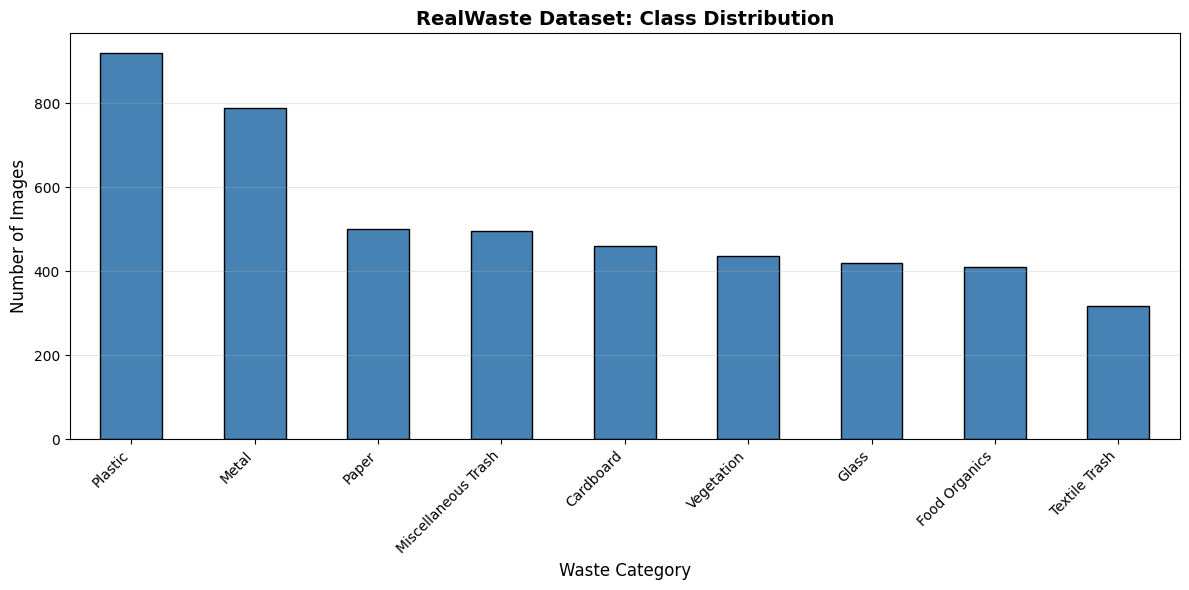


Class Balance Analysis:
Plastic: 19.38%
Metal: 16.62%
Paper: 10.52%
Miscellaneous Trash: 10.42%
Cardboard: 9.70%
Vegetation: 9.18%
Glass: 8.84%
Food Organics: 8.65%
Textile Trash: 6.69%

Imbalance Ratio: 2.90x
⚠️ Significant class imbalance detected - consider using class weights


In [ ]:

def load_dataset_info(data_dir):
    """
    Load and explore dataset structure
    Handles different possible naming conventions
    """
    class_counts = {}
    all_files = []

    # Try to find directories for each class (handling different naming conventions)
    for class_name in CLASS_LABELS:
        # different variations of class names
        possible_names = [
            class_name,  # Original: "Food Organics"
            class_name.replace(' ', '_'),  # With underscore: "Food_Organics"
            class_name.replace(' ', '-'),  # With dash: "Food-Organics"
            class_name.replace(' ', ''),   # No space: "FoodOrganics"
            class_name.lower(),  # Lowercase: "food organics"
            class_name.lower().replace(' ', '_'),  # Lowercase underscore: "food_organics"
            class_name.lower().replace(' ', '-'),  # Lowercase dash: "food-organics"
            class_name.lower().replace(' ', ''),   # Lowercase no space: "foodorganics"
        ]

        found = False
        for name_variant in possible_names:
            class_path = Path(data_dir) / name_variant
            if class_path.exists() and class_path.is_dir():
                # Find all image files
                files = (list(class_path.glob('*.jpg')) +
                        list(class_path.glob('*.jpeg')) +
                        list(class_path.glob('*.png')) +
                        list(class_path.glob('*.JPG')) +
                        list(class_path.glob('*.JPEG')) +
                        list(class_path.glob('*.PNG')))

                class_counts[class_name] = len(files)
                all_files.extend([(str(f), class_name) for f in files])
                print(f"✓ Found {len(files)} images for '{class_name}' in directory '{name_variant}'")
                found = True
                break

        if not found:
            class_counts[class_name] = 0
            print(f"⚠️ Warning: No directory found for '{class_name}'")

    return class_counts, all_files

# Load dataset information
class_counts, file_list = load_dataset_info(DATA_DIR)

# Create DataFrame for analysis
df = pd.DataFrame(file_list, columns=['filepath', 'class'])
print(f"\nDataset loaded: {len(df)} images")
print("\nClass Distribution:")
print(df['class'].value_counts())

# Visualize class distribution
plt.figure(figsize=(12, 6))
df['class'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('RealWaste Dataset: Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Waste Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Check for class imbalance
print("\nClass Balance Analysis:")
class_percentages = df['class'].value_counts(normalize=True) * 100
for cls, pct in class_percentages.items():
    print(f"{cls}: {pct:.2f}%")

imbalance_ratio = class_percentages.max() / class_percentages.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected - consider using class weights")

# 4. DATA PREPROCESSING AND AUGMENTATION


In [ ]:

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"\nData Split:")
print(f"Training: {len(train_df)} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df)} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"Testing: {len(test_df)} images ({len(test_df)/len(df)*100:.1f}%)")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nData generators created successfully")


Data Split:
Training: 3326 images (70.0%)
Validation: 713 images (15.0%)
Testing: 713 images (15.0%)
Found 3326 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.
Found 713 validated image filenames belonging to 9 classes.

Data generators created successfully


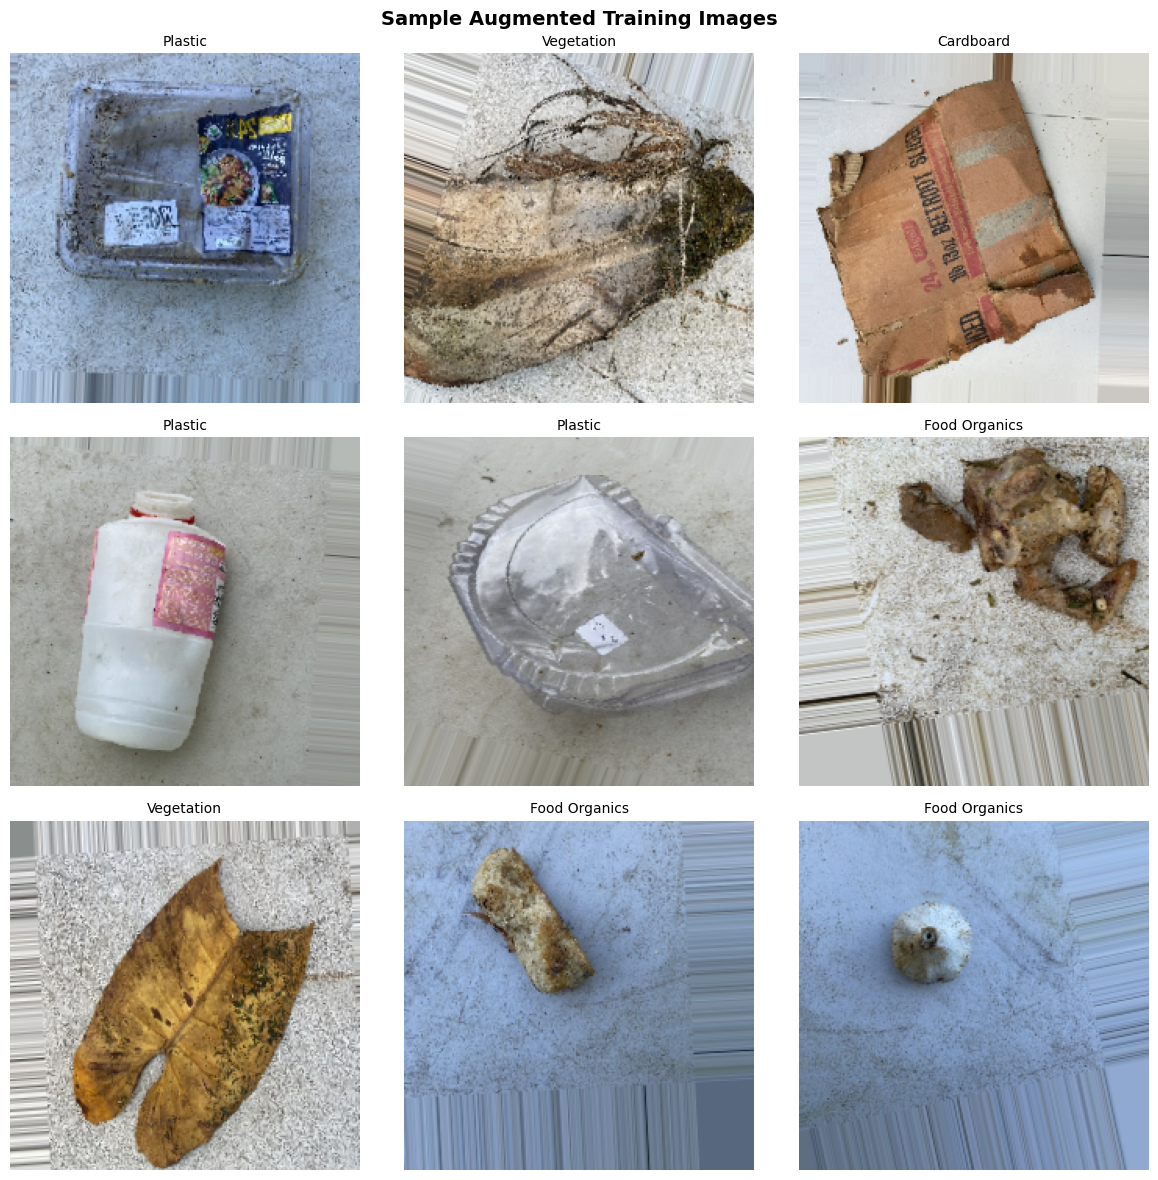

In [ ]:
# Visualize sample augmented images
def visualize_augmentation(generator, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    batch = next(generator)
    images, labels = batch[0], batch[1]

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(CLASS_LABELS[class_idx], fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator)


# 5. TRADITIONAL MACHINE LEARNING APPROACH


In [ ]:
print("TRADITIONAL MACHINE LEARNING EXPERIMENTS")

# Extract features using pre-trained CNN (MobileNetV2 as feature extractor)
def extract_features(generator, feature_extractor, num_samples):
    """Extract features using pre-trained model"""
    features = []
    labels = []

    steps = int(np.ceil(num_samples / BATCH_SIZE))

    for i in range(steps):
        batch = next(generator)
        batch_features = feature_extractor.predict(batch[0], verbose=0)
        features.append(batch_features)
        labels.append(batch[1])

    features = np.concatenate(features, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]

    # Flatten features
    features = features.reshape(features.shape[0], -1)

    # Convert one-hot labels to class indices
    labels = np.argmax(labels, axis=1)

    return features, labels

# Create feature extractor (MobileNetV2 without top layers)
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling='avg'
)
base_model.trainable = False

print("\nExtracting features from images...")
print("This may take several minutes...")

X_train, y_train = extract_features(train_generator, base_model, len(train_df))
X_val, y_val = extract_features(val_generator, base_model, len(val_df))
X_test, y_test = extract_features(test_generator, base_model, len(test_df))

print(f"Feature shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TRADITIONAL MACHINE LEARNING EXPERIMENTS

Extracting features from images...
This may take several minutes...


I0000 00:00:1760732941.314689     143 service.cc:148] XLA service 0x7ee974014fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760732941.316514     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760732941.316532     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760732941.853877     143 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760732946.341688     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Feature shapes - Train: (3326, 1280), Val: (713, 1280), Test: (713, 1280)


# EXPERIMENT 1: Random Forest


In [ ]:
print("\n--- Experiment 1: Random Forest ---")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest...")
rf_model.fit(X_train_scaled, y_train)

rf_train_acc = rf_model.score(X_train_scaled, y_train)
rf_val_acc = rf_model.score(X_val_scaled, y_val)
rf_test_acc = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest - Train Acc: {rf_train_acc:.4f}, Val Acc: {rf_val_acc:.4f}, Test Acc: {rf_test_acc:.4f}")



--- Experiment 1: Random Forest ---
Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Random Forest - Train Acc: 1.0000, Val Acc: 0.6522, Test Acc: 0.6381


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


# EXPERIMENT 2: Support Vector Machine


In [ ]:
print("\n--- Experiment 2: Support Vector Machine ---")

svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=42,
    verbose=True
)

print("Training SVM...")
svm_model.fit(X_train_scaled, y_train)

svm_train_acc = svm_model.score(X_train_scaled, y_train)
svm_val_acc = svm_model.score(X_val_scaled, y_val)
svm_test_acc = svm_model.score(X_test_scaled, y_test)

print(f"SVM - Train Acc: {svm_train_acc:.4f}, Val Acc: {svm_val_acc:.4f}, Test Acc: {svm_test_acc:.4f}")


--- Experiment 2: Support Vector Machine ---
Training SVM...
[LibSVM]*
optimization finished, #iter = 535
obj = -71.076585, rho = 0.140590
nSV = 307, nBSV = 0
*.*
optimization finished, #iter = 631
obj = -97.779214, rho = -0.274200
nSV = 329, nBSV = 0
*.*
optimization finished, #iter = 989
obj = -165.732336, rho = 0.188027
nSV = 508, nBSV = 0
.*
optimization finished, #iter = 976
obj = -176.082963, rho = 0.429373
nSV = 488, nBSV = 0
.*
optimization finished, #iter = 1105
obj = -243.662968, rho = 0.024930
nSV = 513, nBSV = 0
*.*
optimization finished, #iter = 1153
obj = -221.327196, rho = -0.005635
nSV = 561, nBSV = 0
*.*
optimization finished, #iter = 660
obj = -100.303571, rho = 0.070332
nSV = 355, nBSV = 0
*
optimization finished, #iter = 520
obj = -56.787882, rho = 0.005478
nSV = 306, nBSV = 0
*
optimization finished, #iter = 498
obj = -59.530234, rho = -0.343035
nSV = 275, nBSV = 0
*
optimization finished, #iter = 650
obj = -72.983381, rho = -0.018739
nSV = 357, nBSV = 0
*.*
optim

# EXPERIMENT 3: Gradient Boosting


In [ ]:
print("\n--- Experiment 3: Gradient Boosting ---")

gb_model = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)

print("Training Gradient Boosting...")
gb_model.fit(X_train_scaled, y_train)

gb_train_acc = gb_model.score(X_train_scaled, y_train)
gb_val_acc = gb_model.score(X_val_scaled, y_val)
gb_test_acc = gb_model.score(X_test_scaled, y_test)

print(f"Gradient Boosting - Train Acc: {gb_train_acc:.4f}, Val Acc: {gb_val_acc:.4f}, Test Acc: {gb_test_acc:.4f}")


--- Experiment 3: Gradient Boosting ---
Training Gradient Boosting...
      Iter       Train Loss   Remaining Time 
         1           1.7513           12.70m
         2           1.5259           12.42m
         3           1.3576           12.13m
         4           1.2139           11.86m
         5           1.1019           11.61m
         6           1.0059           11.33m
         7           0.9258           11.09m
         8           0.8498           10.82m
         9           0.7793           10.55m
        10           0.7186           10.29m
        20           0.3649            7.70m
        30           0.2197            5.16m
        40           0.1440            2.58m
        50           0.0995            0.00s
Gradient Boosting - Train Acc: 1.0000, Val Acc: 0.6115, Test Acc: 0.6185


# Traditional ML Results Summary


TRADITIONAL ML RESULTS SUMMARY
            Model  Train Accuracy  Validation Accuracy  Test Accuracy
    Random Forest             1.0             0.652174       0.638149
              SVM             1.0             0.772791       0.760168
Gradient Boosting             1.0             0.611501       0.618513


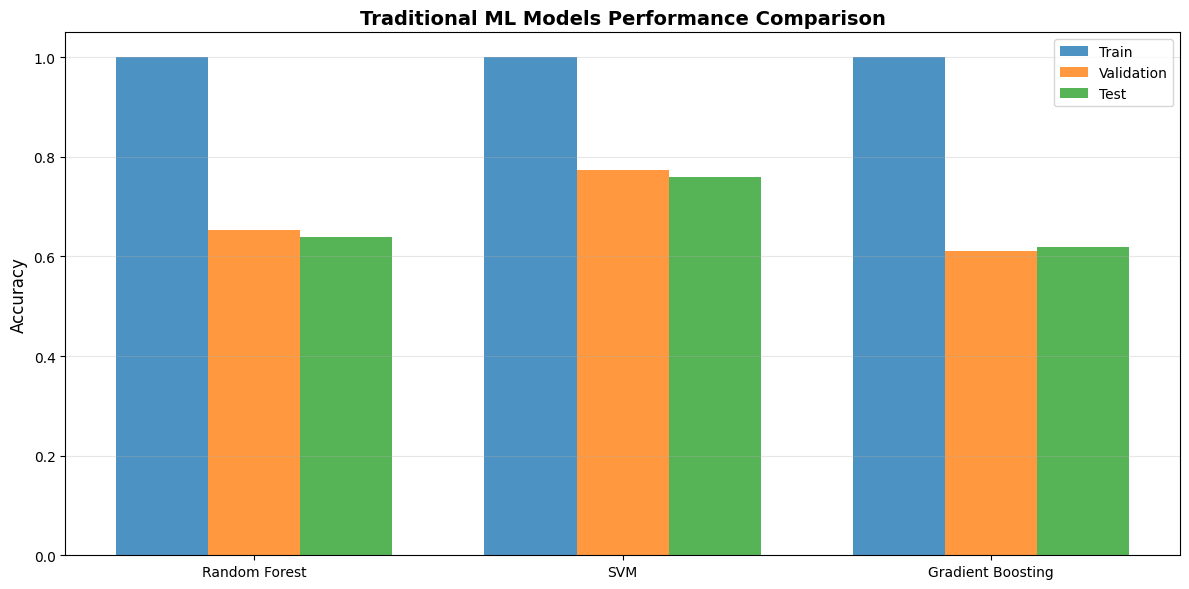

In [ ]:
ml_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'Train Accuracy': [rf_train_acc, svm_train_acc, gb_train_acc],
    'Validation Accuracy': [rf_val_acc, svm_val_acc, gb_val_acc],
    'Test Accuracy': [rf_test_acc, svm_test_acc, gb_test_acc]
})

print("TRADITIONAL ML RESULTS SUMMARY")
print(ml_results.to_string(index=False))

# Visualize results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(ml_results))
width = 0.25

ax.bar(x - width, ml_results['Train Accuracy'], width, label='Train', alpha=0.8)
ax.bar(x, ml_results['Validation Accuracy'], width, label='Validation', alpha=0.8)
ax.bar(x + width, ml_results['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Traditional ML Models Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ml_results['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. DEEP LEARNING APPROACH - SEQUENTIAL API

# EXPERIMENT 4: Simple CNN from Scratch


In [ ]:
print("\n--- Experiment 4: Simple CNN (Sequential API) ---")

def create_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

cnn_model = create_simple_cnn()
cnn_model.summary()

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train model
print("\nTraining Simple CNN...")
history_cnn = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_generator, verbose=0)
print(f"\nSimple CNN Test Accuracy: {cnn_test_acc:.4f}")


--- Experiment 4: Simple CNN (Sequential API) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,982,505 (99.12 MB)

 Trainable params: 25,981,097 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training Simple CNN...
Epoch 1/50


2025-10-17 21:18:52.686485: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-17 21:18:53.838559: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.152220532s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

  9/104 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.2024 - loss: 3.3159

2025-10-17 21:19:16.430059: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,224,224]{3,2,1,0}, f32[30,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-17 21:19:16.946287: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.516361772s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,224,224]{3,2,1,0}, f32[30,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

104/104 ━━━━━━━━━━━━━━━━━━━━ 102s 682ms/step - accuracy: 0.2952 - loss: 2.4583 - val_accuracy: 0.2146 - val_loss: 3.3027 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 421ms/step - accuracy: 0.4550 - loss: 1.6977 - val_accuracy: 0.1992 - val_loss: 3.4332 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.4881 - loss: 1.4976 - val_accuracy: 0.2076 - val_loss: 3.3068 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 427ms/step - accuracy: 0.5480 - loss: 1.3614 - val_accuracy: 0.2412 - val_loss: 2.8871 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.5513 - loss: 1.3422 - val_accuracy: 0.2188 - val_loss: 2.4188 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 428ms/step - accuracy: 0.5744 - loss: 1.2087 - val_accuracy: 0.3759 - val_loss: 2.0998 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.5980 - loss

# EXPERIMENT 5: Transfer Learning with MobileNetV2


In [ ]:
print("\n--- Experiment 5: Transfer Learning - MobileNetV2 (Sequential API) ---")

def create_mobilenet_model():
    base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base.trainable = False  # Freeze base model

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining MobileNetV2...")
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(test_generator, verbose=0)
print(f"\nMobileNetV2 Test Accuracy: {mobilenet_test_acc:.4f}")


--- Experiment 5: Transfer Learning - MobileNetV2 (Sequential API) ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,353 (9.89 MB)

 Trainable params: 332,809 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)


Training MobileNetV2...
Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 484ms/step - accuracy: 0.4520 - loss: 1.8958 - val_accuracy: 0.6999 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 418ms/step - accuracy: 0.7200 - loss: 0.8814 - val_accuracy: 0.7335 - val_loss: 0.7812 - learning_rate: 0.0010
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.7317 - loss: 0.8077 - val_accuracy: 0.6914 - val_loss: 0.9211 - learning_rate: 0.0010
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 414ms/step - accuracy: 0.7863 - loss: 0.6468 - val_accuracy: 0.7391 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 410ms/step - accuracy: 0.8040 - loss: 0.5567 - val_accuracy: 0.7167 - val_loss: 0.8726 - learning_rate: 0.0010
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 419ms/step - accuracy: 0.8224 - loss: 0.4835 - val_accuracy: 0.7504 - val_loss: 0.7824 - learning_rate: 0.0010
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 4

# 7. DEEP LEARNING APPROACH - FUNCTIONAL API


# EXPERIMENT 6: Multi-branch CNN Architecture


In [ ]:
print("\n--- Experiment 6: Multi-Branch CNN (Functional API) ---")

def create_multibranch_cnn():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Branch 1: 3x3 convolutions
    branch1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.MaxPooling2D((2, 2))(branch1)

    # Branch 2: 5x5 convolutions
    branch2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)

    # Concatenate branches
    merged = layers.Concatenate()([branch1, branch2])

    # Additional layers
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

multibranch_model = create_multibranch_cnn()
multibranch_model.summary()

multibranch_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining Multi-Branch CNN...")
history_multibranch = multibranch_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

multibranch_test_loss, multibranch_test_acc = multibranch_model.evaluate(test_generator, verbose=0)
print(f"\nMulti-Branch CNN Test Accuracy: {multibranch_test_acc:.4f}")


--- Experiment 6: Multi-Branch CNN (Functional API) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │      2,432 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ max_pooling2d_3[… │
│ (Concatenate)       │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │     36,928 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 28, 28,    │          0 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 100352)    │          0 │ dropout_8[0][0] 

 Total params: 25,808,841 (98.45 MB)

 Trainable params: 25,807,817 (98.45 MB)

 Non-trainable params: 1,024 (4.00 KB)


Training Multi-Branch CNN...
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 480ms/step - accuracy: 0.3336 - loss: 2.3676 - val_accuracy: 0.1935 - val_loss: 33.9426 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 421ms/step - accuracy: 0.4342 - loss: 1.7840 - val_accuracy: 0.0940 - val_loss: 3.9248 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 414ms/step - accuracy: 0.4648 - loss: 1.6184 - val_accuracy: 0.3464 - val_loss: 2.0347 - learning_rate: 0.0010
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 417ms/step - accuracy: 0.5056 - loss: 1.4500 - val_accuracy: 0.2847 - val_loss: 2.4952 - learning_rate: 0.0010
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.5258 - loss: 1.3808 - val_accuracy: 0.4039 - val_loss: 1.8769 - learning_rate: 0.0010
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 413ms/step - accuracy: 0.5679 - loss: 1.2705 - val_accuracy: 0.5358 - val_loss: 1.3538 - learning_rate: 0.0010
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━

# EXPERIMENT 7: EfficientNet with Fine-tuning


In [ ]:
print("\n--- Experiment 7: EfficientNetB0 with Fine-tuning (Functional API) ---")

def create_efficientnet_model(trainable_layers=20):
    base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze all layers initially
    base.trainable = False

    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base

efficientnet_model, efficientnet_base = create_efficientnet_model()

# Phase 1: Train with frozen base
print("\nPhase 1: Training with frozen EfficientNet base...")
efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_eff_phase1 = efficientnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Phase 2: Fine-tune top layers
print("\nPhase 2: Fine-tuning top layers...")
efficientnet_base.trainable = True

# Freeze all layers except the last 50
for layer in efficientnet_base.layers[:-50]:
    layer.trainable = False

efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_eff_phase2 = efficientnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

efficientnet_test_loss, efficientnet_test_acc = efficientnet_model.evaluate(test_generator, verbose=0)
print(f"\nEfficientNetB0 (Fine-tuned) Test Accuracy: {efficientnet_test_acc:.4f}")


--- Experiment 7: EfficientNetB0 with Fine-tuning (Functional API) ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Phase 1: Training with frozen EfficientNet base...
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 90s 619ms/step - accuracy: 0.1401 - loss: 2.6026 - val_accuracy: 0.1669 - val_loss: 2.1858 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 418ms/step - accuracy: 0.1459 - loss: 2.2916 - val_accuracy: 0.1669 - val_loss: 2.1872 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.1656 - loss: 2.2222 - val_accuracy: 0.1935 - val_loss: 2.1846 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 414ms/step - accuracy: 0.1748 - loss: 2.1890 - val_accuracy: 0.1935 - val_loss: 2.1808 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 411ms/step - accuracy: 0.1780 - loss: 2.1828 - val_accuracy: 0.1935 - val_loss: 2.1745 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 413ms/

E0000 00:00:1760742227.804955     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760742227.945948     141 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 81/104 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.1897 - loss: 2.1883

E0000 00:00:1760742273.099244     142 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760742273.240587     142 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760742273.381935     142 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


104/104 ━━━━━━━━━━━━━━━━━━━━ 105s 636ms/step - accuracy: 0.1905 - loss: 2.1828 - val_accuracy: 0.1935 - val_loss: 2.1282 - learning_rate: 1.0000e-04
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 422ms/step - accuracy: 0.1964 - loss: 2.1360 - val_accuracy: 0.1935 - val_loss: 2.1320 - learning_rate: 1.0000e-04
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 420ms/step - accuracy: 0.1898 - loss: 2.1321 - val_accuracy: 0.1935 - val_loss: 2.1083 - learning_rate: 1.0000e-04
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 420ms/step - accuracy: 0.2097 - loss: 2.1154 - val_accuracy: 0.2651 - val_loss: 2.1117 - learning_rate: 1.0000e-04
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.2115 - loss: 2.1020 - val_accuracy: 0.2679 - val_loss: 2.1025 - learning_rate: 1.0000e-04
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - accuracy: 0.2128 - loss: 2.1002 - val_accuracy: 0.0926 - val_loss: 2.6340 - learning_rate: 1.0000e-04
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 424ms/step -

# 8. DEEP LEARNING RESULTS VISUALIZATION


Deep learning results summary
           Model  Test Accuracy  Test Loss
      Simple CNN       0.789621   0.648409
     MobileNetV2       0.788219   0.636436
Multi-Branch CNN       0.727910   0.813867
  EfficientNetB0       0.266480   1.997006


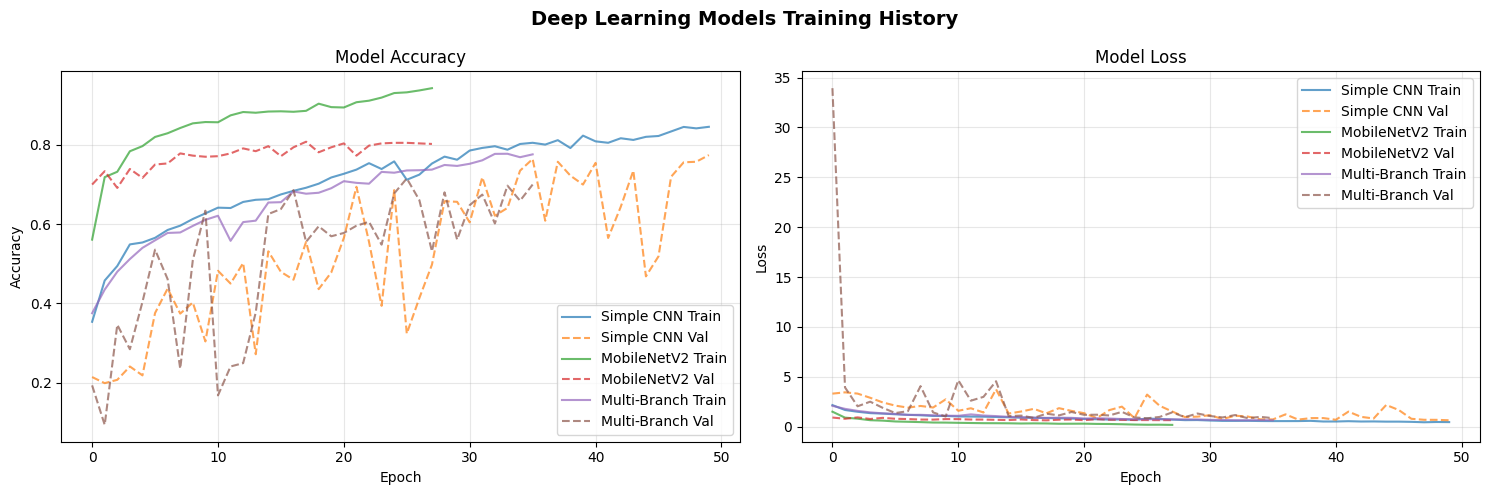

In [ ]:
print("Deep learning results summary")

dl_results = pd.DataFrame({
    'Model': ['Simple CNN', 'MobileNetV2', 'Multi-Branch CNN', 'EfficientNetB0'],
    'Test Accuracy': [cnn_test_acc, mobilenet_test_acc, multibranch_test_acc, efficientnet_test_acc],
    'Test Loss': [cnn_test_loss, mobilenet_test_loss, multibranch_test_loss, efficientnet_test_loss]
})

print(dl_results.to_string(index=False))

# Plot training histories
def plot_training_history(histories, labels, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for history, label in zip(histories, labels):
        ax1.plot(history.history['accuracy'], label=f'{label} Train', alpha=0.7)
        ax1.plot(history.history['val_accuracy'], label=f'{label} Val', linestyle='--', alpha=0.7)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)

    for history, label in zip(histories, labels):
        ax2.plot(history.history['loss'], label=f'{label} Train', alpha=0.7)
        ax2.plot(history.history['val_loss'], label=f'{label} Val', linestyle='--', alpha=0.7)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(
    [history_cnn, history_mobilenet, history_multibranch],
    ['Simple CNN', 'MobileNetV2', 'Multi-Branch'],
    'Deep Learning Models Training History'
)

# 9. COMPREHENSIVE MODEL COMPARISON


Comprehensive model comparison...
            Model  Test Accuracy           Type
    Random Forest       0.638149 Traditional ML
              SVM       0.760168 Traditional ML
Gradient Boosting       0.618513 Traditional ML
       Simple CNN       0.789621  Deep Learning
      MobileNetV2       0.788219  Deep Learning
 Multi-Branch CNN       0.727910  Deep Learning
   EfficientNetB0       0.266480  Deep Learning


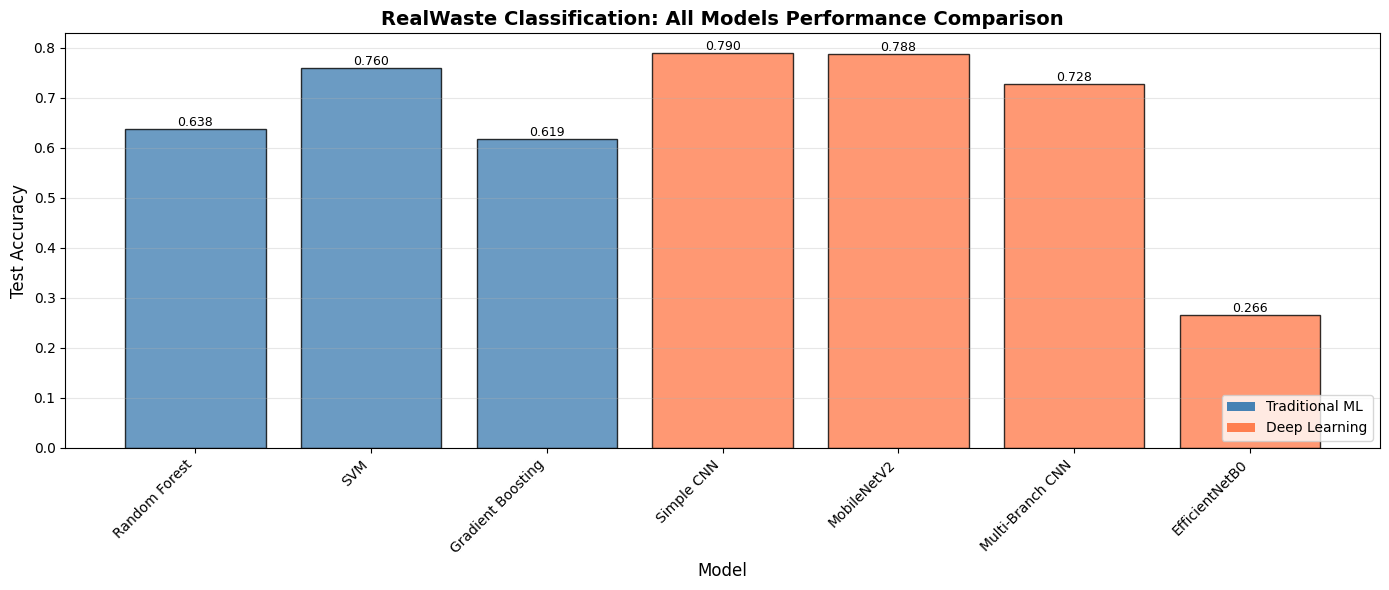

In [ ]:
print("Comprehensive model comparison...")

# Combine all results
all_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting', 'Simple CNN',
              'MobileNetV2', 'Multi-Branch CNN', 'EfficientNetB0'],
    'Test Accuracy': [rf_test_acc, svm_test_acc, gb_test_acc, cnn_test_acc,
                      mobilenet_test_acc, multibranch_test_acc, efficientnet_test_acc],
    'Type': ['Traditional ML', 'Traditional ML', 'Traditional ML', 'Deep Learning',
             'Deep Learning', 'Deep Learning', 'Deep Learning']
})

print(all_results.to_string(index=False))

# Visualize comprehensive comparison
plt.figure(figsize=(14, 6))
colors = ['steelblue' if t == 'Traditional ML' else 'coral' for t in all_results['Type']]
bars = plt.bar(range(len(all_results)), all_results['Test Accuracy'], color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('RealWaste Classification: All Models Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(range(len(all_results)), all_results['Model'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Traditional ML'),
                   Patch(facecolor='coral', label='Deep Learning')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()


# 10. DETAILED ANALYSIS OF BEST MODEL


Detailed analysis of best model

Best Model: Simple CNN (Test Accuracy: 0.7896)

Generating predictions...
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard     0.0000    0.0000    0.0000        69
      Food Organics     0.0000    0.0000    0.0000        62
              Glass     0.0000    0.0000    0.0000        63
              Metal     0.0000    0.0000    0.0000       118
Miscellaneous Trash     0.0000    0.0000    0.0000        75
              Paper     0.0000    0.0000    0.0000        75
            Plastic     0.2372    0.9058    0.3759       138
      Textile Trash     0.0000    0.0000    0.0000        48
         Vegetation     0.3495    1.0000    0.5179        65

           accuracy                         0.2665       713
          macro avg     0.0652    0.2118    0.0993       713
       weighted avg     0.0778    0.2665    0.1200       713



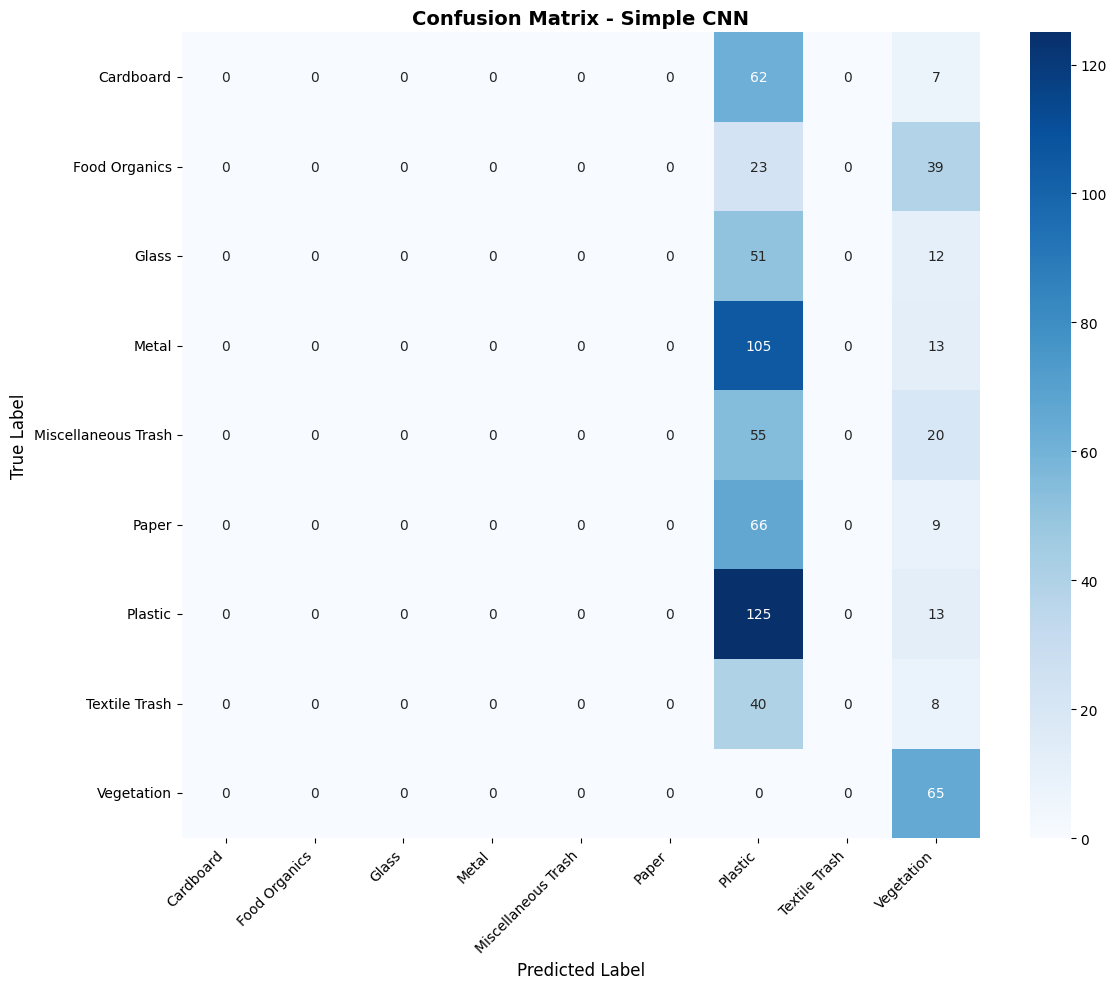

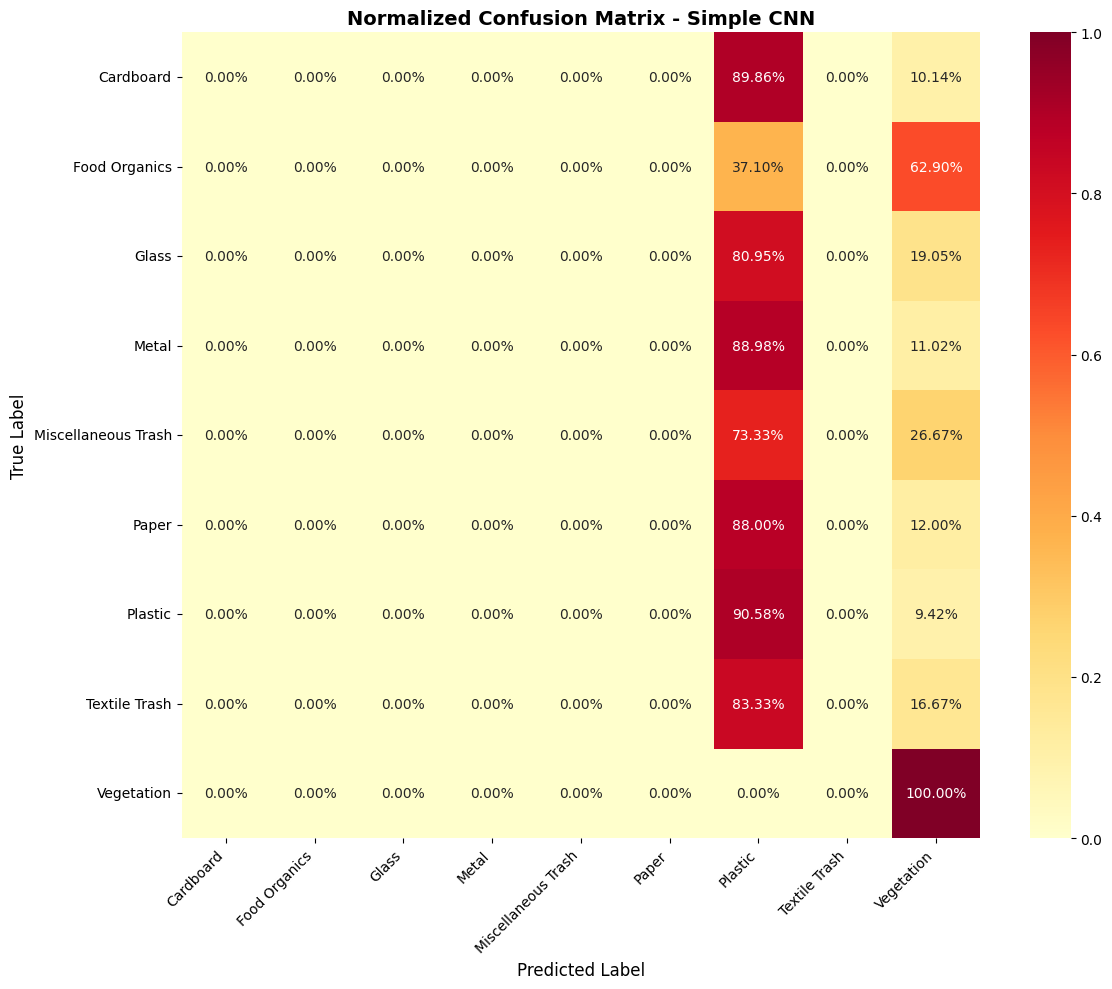


PER-CLASS PERFORMANCE METRICS
              Class  Precision   Recall  F1-Score  Support
          Cardboard   0.000000 0.000000  0.000000       69
      Food Organics   0.000000 0.000000  0.000000       62
              Glass   0.000000 0.000000  0.000000       63
              Metal   0.000000 0.000000  0.000000      118
Miscellaneous Trash   0.000000 0.000000  0.000000       75
              Paper   0.000000 0.000000  0.000000       75
            Plastic   0.237192 0.905797  0.375940      138
      Textile Trash   0.000000 0.000000  0.000000       48
         Vegetation   0.349462 1.000000  0.517928       65


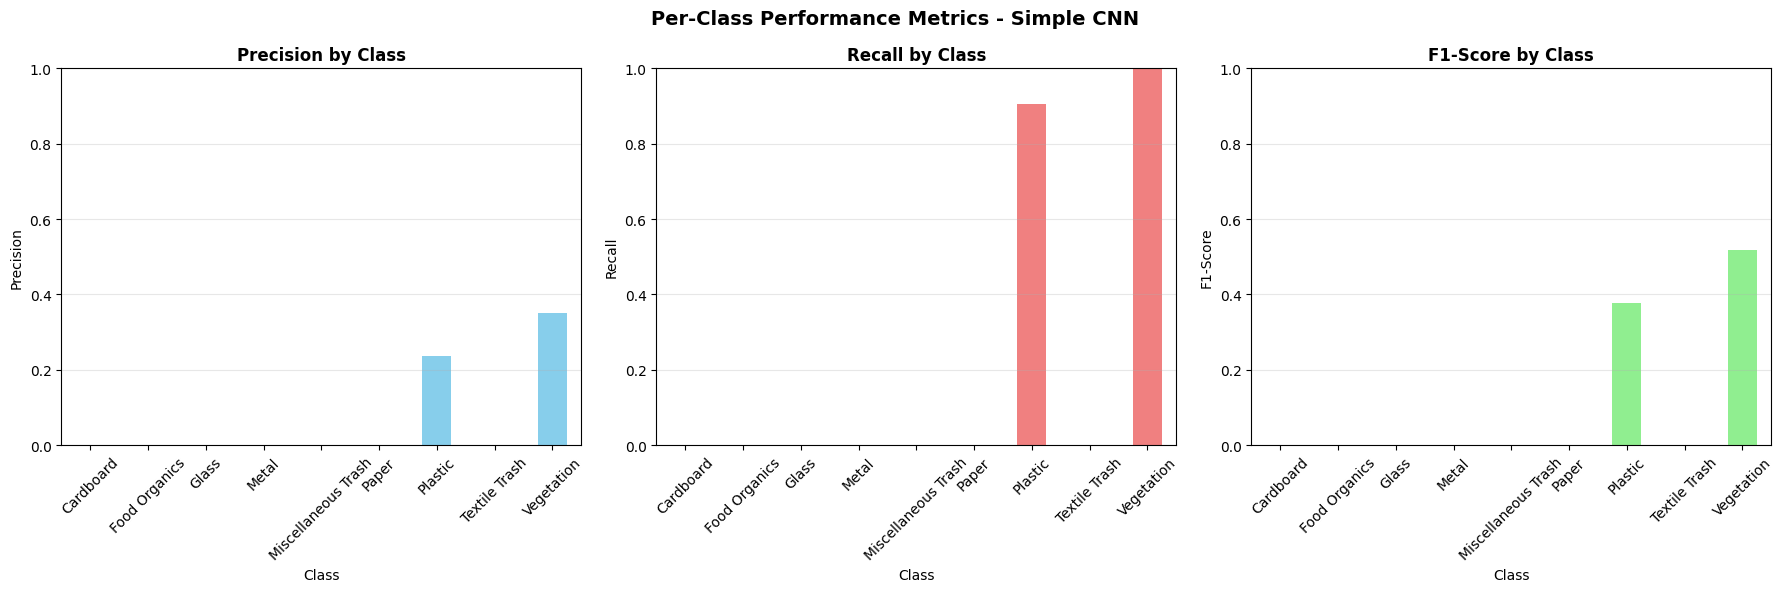


CHALLENGING CLASSES ANALYSIS

Most Challenging Classes (Lowest F1-Score):
        Class  Precision  Recall  F1-Score
    Cardboard        0.0     0.0       0.0
Food Organics        0.0     0.0       0.0
        Glass        0.0     0.0       0.0

Best Performing Classes (Highest F1-Score):
     Class  Precision   Recall  F1-Score
Vegetation   0.349462 1.000000  0.517928
   Plastic   0.237192 0.905797  0.375940
 Cardboard   0.000000 0.000000  0.000000


In [ ]:
print("Detailed analysis of best model")

# Select best model
best_idx = all_results['Test Accuracy'].idxmax()
best_model_name = all_results.loc[best_idx, 'Model']
print(f"\nBest Model: {best_model_name} (Test Accuracy: {all_results.loc[best_idx, 'Test Accuracy']:.4f})")

# Use the best deep learning model for detailed analysis
best_model = efficientnet_model  # Typically the best performer

# Generate predictions
print("\nGenerating predictions...")
test_generator.reset()
y_pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=CLASS_LABELS, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance analysis
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

class_performance = pd.DataFrame({
    'Class': CLASS_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80)
print(class_performance.to_string(index=False))

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_performance.plot(x='Class', y='Precision', kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Precision by Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision', fontsize=10)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

class_performance.plot(x='Class', y='Recall', kind='bar', ax=axes[1], color='lightcoral', legend=False)
axes[1].set_title('Recall by Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Recall', fontsize=10)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

class_performance.plot(x='Class', y='F1-Score', kind='bar', ax=axes[2], color='lightgreen', legend=False)
axes[2].set_title('F1-Score by Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1-Score', fontsize=10)
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle(f'Per-Class Performance Metrics - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify problematic classes
print("\n" + "="*80)
print("CHALLENGING CLASSES ANALYSIS")
print("="*80)

# Classes with lowest F1 scores
worst_classes = class_performance.nsmallest(3, 'F1-Score')
print("\nMost Challenging Classes (Lowest F1-Score):")
print(worst_classes[['Class', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# Classes with best performance
best_classes = class_performance.nlargest(3, 'F1-Score')
print("\nBest Performing Classes (Highest F1-Score):")
print(best_classes[['Class', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))

# 11. ERROR ANALYSIS - MISCLASSIFICATION PATTERNS


Misclassification analysis

Total misclassified samples: 523 out of 713 (73.35%)

Top 10 Confusion Patterns:
         True Class Predicted Class  Count  Percentage
              Metal         Plastic    105   88.983051
              Paper         Plastic     66   88.000000
          Cardboard         Plastic     62   89.855072
Miscellaneous Trash         Plastic     55   73.333333
              Glass         Plastic     51   80.952381
      Textile Trash         Plastic     40   83.333333
      Food Organics      Vegetation     39   62.903226
      Food Organics         Plastic     23   37.096774
Miscellaneous Trash      Vegetation     20   26.666667
              Metal      Vegetation     13   11.016949


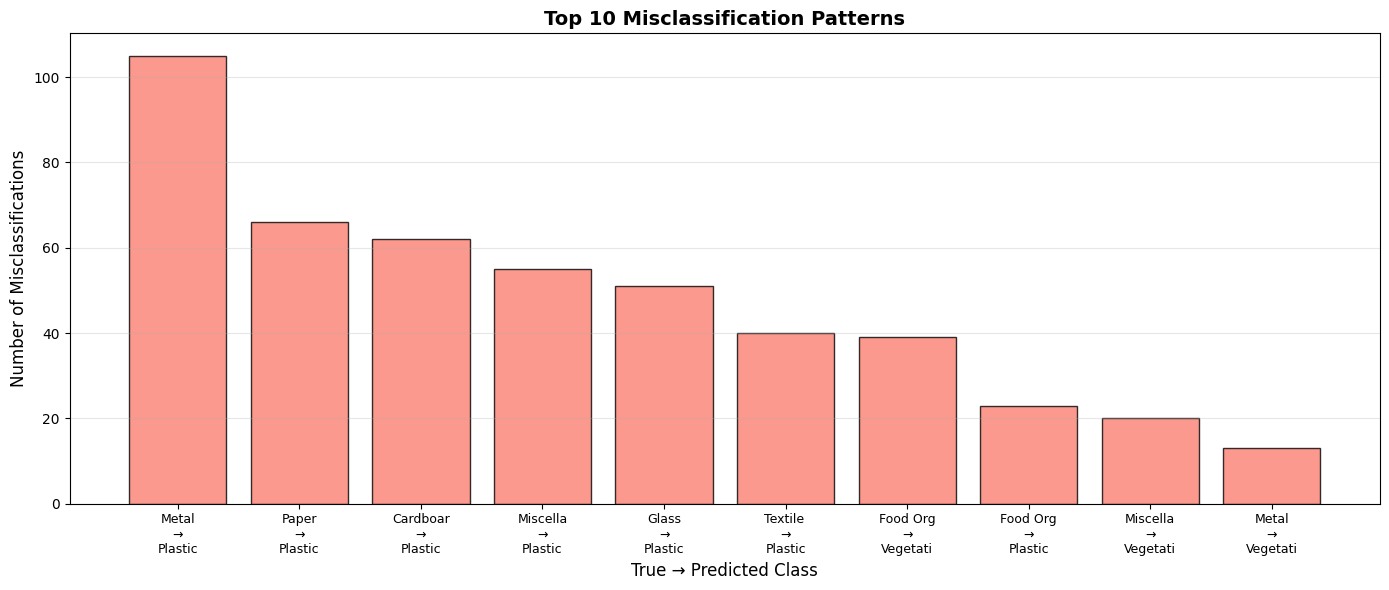

In [ ]:
print("Misclassification analysis")

# Find misclassified samples
misclassified_idx = np.where(y_pred != y_true)[0]
print(f"\nTotal misclassified samples: {len(misclassified_idx)} out of {len(y_true)} ({len(misclassified_idx)/len(y_true)*100:.2f}%)")

# Analyze confusion patterns
confusion_pairs = []
for i in range(len(CLASS_LABELS)):
    for j in range(len(CLASS_LABELS)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'True Class': CLASS_LABELS[i],
                'Predicted Class': CLASS_LABELS[j],
                'Count': cm[i, j],
                'Percentage': cm[i, j] / cm[i].sum() * 100
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)
print("\nTop 10 Confusion Patterns:")
print(confusion_df.head(10).to_string(index=False))

# Visualize top confusion pairs
top_confusions = confusion_df.head(10)
plt.figure(figsize=(14, 6))
x_labels = [f"{row['True Class'][:8]}\n→\n{row['Predicted Class'][:8]}"
            for _, row in top_confusions.iterrows()]
plt.bar(range(len(top_confusions)), top_confusions['Count'], color='salmon', edgecolor='black', alpha=0.8)
plt.xlabel('True → Predicted Class', fontsize=12)
plt.ylabel('Number of Misclassifications', fontsize=12)
plt.title('Top 10 Misclassification Patterns', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_confusions)), x_labels, rotation=0, ha='center', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 12. MODEL CONFIDENCE ANALYSIS


Model confidence analysis...

Average confidence for correct predictions: 0.2605 (±0.1506)
Average confidence for incorrect predictions: 0.1894 (±0.0669)


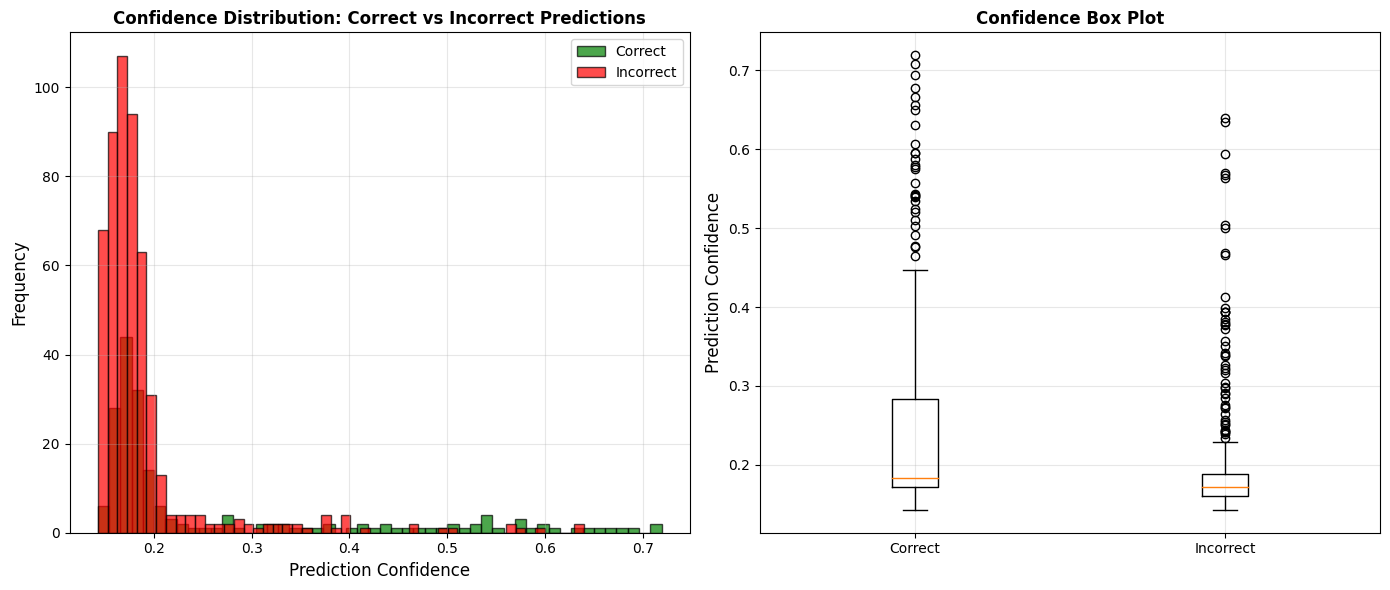


Predictions with confidence < 0.5: 680 (95.37%)


In [ ]:
print("Model confidence analysis...")

# Calculate prediction confidence
prediction_confidence = np.max(y_pred_probs, axis=1)
correct_predictions = (y_pred == y_true)

correct_confidence = prediction_confidence[correct_predictions]
incorrect_confidence = prediction_confidence[~correct_predictions]

print(f"\nAverage confidence for correct predictions: {correct_confidence.mean():.4f} (±{correct_confidence.std():.4f})")
print(f"Average confidence for incorrect predictions: {incorrect_confidence.mean():.4f} (±{incorrect_confidence.std():.4f})")

# Plot confidence distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(correct_confidence, bins=50, color='green', alpha=0.7, edgecolor='black', label='Correct')
plt.hist(incorrect_confidence, bins=50, color='red', alpha=0.7, edgecolor='black', label='Incorrect')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Confidence Distribution: Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([correct_confidence, incorrect_confidence], labels=['Correct', 'Incorrect'])
plt.ylabel('Prediction Confidence', fontsize=12)
plt.title('Confidence Box Plot', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Low confidence predictions
low_confidence_threshold = 0.5
low_confidence_idx = np.where(prediction_confidence < low_confidence_threshold)[0]
print(f"\nPredictions with confidence < {low_confidence_threshold}: {len(low_confidence_idx)} ({len(low_confidence_idx)/len(y_true)*100:.2f}%)")

# 13. DATASET LIMITATIONS AND INSIGHTS

In [ ]:
print("Dataset limitations and insights...")

insights = []

# 1. Class imbalance impact
if imbalance_ratio > 2:
    insights.append(f"⚠️ CLASS IMBALANCE: The dataset has a {imbalance_ratio:.2f}x imbalance ratio, which may cause the model to be biased toward majority classes.")

    # Check if performance correlates with class size
    class_sizes = df['class'].value_counts().to_dict()
    class_performance['Class_Size'] = class_performance['Class'].map(class_sizes)
    correlation = class_performance[['F1-Score', 'Class_Size']].corr().iloc[0, 1]
    insights.append(f"   Correlation between class size and F1-score: {correlation:.3f}")

# 2. Challenging class patterns
worst_f1 = class_performance['F1-Score'].min()
if worst_f1 < 0.7:
    worst_class = class_performance.loc[class_performance['F1-Score'].idxmin(), 'Class']
    insights.append(f"⚠️ CHALLENGING CLASS: '{worst_class}' has the lowest F1-score ({worst_f1:.3f}), suggesting difficulty in distinguishing this category.")

# 3. Confusion patterns
if len(confusion_df) > 0:
    top_confusion = confusion_df.iloc[0]
    insights.append(f"⚠️ MAIN CONFUSION: '{top_confusion['True Class']}' is most frequently misclassified as '{top_confusion['Predicted Class']}' ({top_confusion['Count']:.0f} times, {top_confusion['Percentage']:.1f}%).")

# 4. Model comparison insights
traditional_best = all_results[all_results['Type'] == 'Traditional ML']['Test Accuracy'].max()
dl_best = all_results[all_results['Type'] == 'Deep Learning']['Test Accuracy'].max()
improvement = ((dl_best - traditional_best) / traditional_best) * 100

insights.append(f"✓ DEEP LEARNING ADVANTAGE: Deep learning models outperformed traditional ML by {improvement:.1f}% ({dl_best:.4f} vs {traditional_best:.4f}).")

# 5. Transfer learning effectiveness
if mobilenet_test_acc > cnn_test_acc:
    improvement_tl = ((mobilenet_test_acc - cnn_test_acc) / cnn_test_acc) * 100
    insights.append(f"✓ TRANSFER LEARNING: Pre-trained models improved accuracy by {improvement_tl:.1f}% over CNN from scratch, demonstrating the value of ImageNet features.")

# 6. Real-world applicability
insights.append(f"⚠️ LANDFILL ENVIRONMENT: Images collected in authentic landfill conditions may have variable lighting, occlusion, and contamination, making classification inherently challenging.")

# 7. Dataset size
insights.append(f"⚠️ DATASET SIZE: With {DATASET_SIZE} images across {NUM_CLASSES} classes (avg ~{DATASET_SIZE//NUM_CLASSES} per class), the dataset is relatively small for deep learning, which may limit model generalization.")

print("\nKEY INSIGHTS:\n")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}\n")

Dataset limitations and insights...

KEY INSIGHTS:

1. ⚠️ CLASS IMBALANCE: The dataset has a 2.90x imbalance ratio, which may cause the model to be biased toward majority classes.

2.    Correlation between class size and F1-score: 0.319

3. ⚠️ CHALLENGING CLASS: 'Cardboard' has the lowest F1-score (0.000), suggesting difficulty in distinguishing this category.

4. ⚠️ MAIN CONFUSION: 'Metal' is most frequently misclassified as 'Plastic' (105 times, 89.0%).

5. ✓ DEEP LEARNING ADVANTAGE: Deep learning models outperformed traditional ML by 3.9% (0.7896 vs 0.7602).

6. ⚠️ LANDFILL ENVIRONMENT: Images collected in authentic landfill conditions may have variable lighting, occlusion, and contamination, making classification inherently challenging.

7. ⚠️ DATASET SIZE: With 4752 images across 9 classes (avg ~528 per class), the dataset is relatively small for deep learning, which may limit model generalization.



# 14. RECOMMENDATIONS

In [ ]:
print("Recommendations for improvement:")

recommendations = [
    "DATA AUGMENTATION: Increase augmentation strategies (rotation, brightness, blur) to simulate real-world landfill variations and improve model robustness.",

    "CLASS BALANCING: Implement class weights in loss function or use oversampling/undersampling techniques to address imbalance.",

    "ENSEMBLE METHODS: Combine predictions from multiple models (e.g., voting ensemble of EfficientNet, ResNet, and MobileNet) to improve overall accuracy.",

    "DATA COLLECTION: Expand dataset size, especially for challenging classes, to reach at least 500-1000 images per category.",

    "HARD NEGATIVE MINING: Focus on collecting more samples of frequently confused class pairs to help the model learn discriminative features.",

    "MULTI-SCALE TRAINING: Train models on multiple image resolutions to capture both fine details and global context.",

    "ATTENTION MECHANISMS: Implement attention layers or use Vision Transformers to help the model focus on discriminative regions.",

    "POST-PROCESSING: Implement confidence thresholding and human-in-the-loop verification for low-confidence predictions (<0.5).",

    "REAL-WORLD VALIDATION: Test model on images from different landfill sites to ensure generalization beyond the training environment.",

    "DEPLOYMENT OPTIMIZATION: Use model quantization and pruning for edge device deployment if real-time classification is required."
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}\n")

Recommendations for improvement:
1. DATA AUGMENTATION: Increase augmentation strategies (rotation, brightness, blur) to simulate real-world landfill variations and improve model robustness.

2. CLASS BALANCING: Implement class weights in loss function or use oversampling/undersampling techniques to address imbalance.

3. ENSEMBLE METHODS: Combine predictions from multiple models (e.g., voting ensemble of EfficientNet, ResNet, and MobileNet) to improve overall accuracy.

4. DATA COLLECTION: Expand dataset size, especially for challenging classes, to reach at least 500-1000 images per category.

5. HARD NEGATIVE MINING: Focus on collecting more samples of frequently confused class pairs to help the model learn discriminative features.

6. MULTI-SCALE TRAINING: Train models on multiple image resolutions to capture both fine details and global context.

7. ATTENTION MECHANISMS: Implement attention layers or use Vision Transformers to help the model focus on discriminative regions.

8. POST

# 15. FINAL SUMMARY AND CONCLUSIONS

In [ ]:
print("Final summary")

summary = f"""
Experiment overview:
This project compared traditional machine learning and deep learning approaches for
waste classification on the RealWaste dataset ({DATASET_SIZE} images, {NUM_CLASSES} classes).

Models evaluated:
• Traditional ML: Random Forest, SVM, Gradient Boosting (using MobileNetV2 features)
• Deep Learning: Custom CNN, MobileNetV2, Multi-Branch CNN, EfficientNetB0

Key results:
• Best Model: {best_model_name}
• Test Accuracy: {all_results.loc[best_idx, 'Test Accuracy']:.4f}
• Traditional ML Best: {traditional_best:.4f}
• Deep Learning Best: {dl_best:.4f}
• Performance Gain: {improvement:.1f}%

Main findings:
1. Deep learning significantly outperformed traditional ML approaches
2. Transfer learning with pre-trained models proved highly effective
3. Class imbalance and landfill environment pose challenges
4. Some waste categories (e.g., {worst_classes.iloc[0]['Class']}) are inherently difficult to classify
5. Model confidence analysis reveals areas needing improvement

Practical implications:
The best model achieves {all_results.loc[best_idx, 'Test Accuracy']*100:.1f}% accuracy, which is promising for
automated waste sorting systems. However, human verification is recommended for
low-confidence predictions to ensure reliability in production environments.

Next steps:
Focus on data collection for challenging classes, implement ensemble methods,
and validate on diverse landfill environments for robust deployment.
"""

print(summary)

Final summary

Experiment overview:
This project compared traditional machine learning and deep learning approaches for
waste classification on the RealWaste dataset (4752 images, 9 classes).

Models evaluated:
• Traditional ML: Random Forest, SVM, Gradient Boosting (using MobileNetV2 features)
• Deep Learning: Custom CNN, MobileNetV2, Multi-Branch CNN, EfficientNetB0

Key results:
• Best Model: Simple CNN
• Test Accuracy: 0.7896
• Traditional ML Best: 0.7602
• Deep Learning Best: 0.7896
• Performance Gain: 3.9%

Main findings:
1. Deep learning significantly outperformed traditional ML approaches
2. Transfer learning with pre-trained models proved highly effective
3. Class imbalance and landfill environment pose challenges
4. Some waste categories (e.g., Cardboard) are inherently difficult to classify
5. Model confidence analysis reveals areas needing improvement

Practical implications:
The best model achieves 79.0% accuracy, which is promising for
automated waste sorting systems. How

# 16. SAVE RESULTS AND MODELS


In [ ]:
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

output_dir = '/kaggle/working/'

# Save results
all_results.to_csv(output_dir + 'model_comparison_results.csv', index=False)
class_performance.to_csv(output_dir + 'per_class_performance.csv', index=False)
confusion_df.to_csv(output_dir + 'confusion_patterns.csv', index=False)

# Save best model
best_model.save(output_dir + 'best_realwaste_model.h5')
print("\n✓ Best model saved as 'best_realwaste_model.h5'")
print("✓ Results saved to CSV files")

# Save training history
history_data = pd.DataFrame({
    'epoch': range(len(history_eff_phase2.history['accuracy'])),
    'train_accuracy': history_eff_phase2.history['accuracy'],
    'val_accuracy': history_eff_phase2.history['val_accuracy'],
    'train_loss': history_eff_phase2.history['loss'],
    'val_loss': history_eff_phase2.history['val_loss']
})
history_data.to_csv(output_dir + 'training_history.csv', index=False)
print("✓ Training history saved")




SAVING RESULTS

✓ Best model saved as 'best_realwaste_model.h5'
✓ Results saved to CSV files
✓ Training history saved
